In [1]:
# adding root folder to path
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# third-party imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from modAL.models import ActiveLearner

# project import
from commons.file import save_model
from commons.data import encode_data
from commons.classifiers import get_estimator
from commons.classifiers import get_query_strategy
from commons.classifiers import initial_pool_test_split

## Loading data

In [3]:
df = pd.read_csv('../datasets/vulns-labelled.csv')

# droping unused columns
df.drop(columns=[
    'cve_id', 'readable_cve_date', 'reference',
    'readable_exploit_date', 'audience_normalized'], inplace=True)

# encoding dataset
df = encode_data(df)

df['label'].replace(
    {'LOW': 0, 'MODERATE': 1, 'IMPORTANT': 2, 'CRITICAL': 3}, inplace=True)

X = df.drop(columns='label').to_numpy()
y = df['label'].to_numpy()

In [4]:
feature_names = df.drop(columns='label').columns

## Training Clasify

In [5]:
INITIAL_SIZE = 20
TEST_SIZE = 40
NUMBER_QUERIES = 100
ENCODE_DATA = False
ESTIMATOR = 'gb'
QUERY_STRATEGY = 'entropy-sampling'

In [6]:
X_initial, X_pool, X_test, y_initial, y_pool, y_test =\
    initial_pool_test_split(X, y, INITIAL_SIZE, TEST_SIZE)

if ENCODE_DATA:
    scaler = StandardScaler().fit(np.r_[X_initial, X_pool])
    X_initial = scaler.transform(X_initial)
    X_pool = scaler.transform(X_pool)
    X_test = scaler.transform(X_test)

learner = ActiveLearner(estimator=get_estimator(ESTIMATOR),
                        query_strategy=get_query_strategy(QUERY_STRATEGY),
                        X_training=X_initial, y_training=y_initial)

for _ in range(NUMBER_QUERIES):

    query_idx, query_inst = learner.query(X_pool)

    learner.teach(query_inst.reshape(1, -1), y_pool[query_idx])

    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

In [7]:
y_pred = learner.predict(X_test)

print(f'final score: {learner.score(X_test, y_test):.2f}')

print(f'precision score: {precision_score(y_test, y_pred, average="weighted"):.2f}')
print(f'recall score: {recall_score(y_test, y_pred, average="weighted"):.2f}')
print(f'f1 score: {f1_score(y_test, y_pred, average="weighted"):.2f}')

final score: 0.80
precision score: 0.79
recall score: 0.80
f1 score: 0.78


## Feature analysis

In [8]:
importances = learner.estimator.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)

values = forest_importances.sort_values(ascending=False).values[:10]
indexes = forest_importances.sort_values(ascending=False).index[:10]

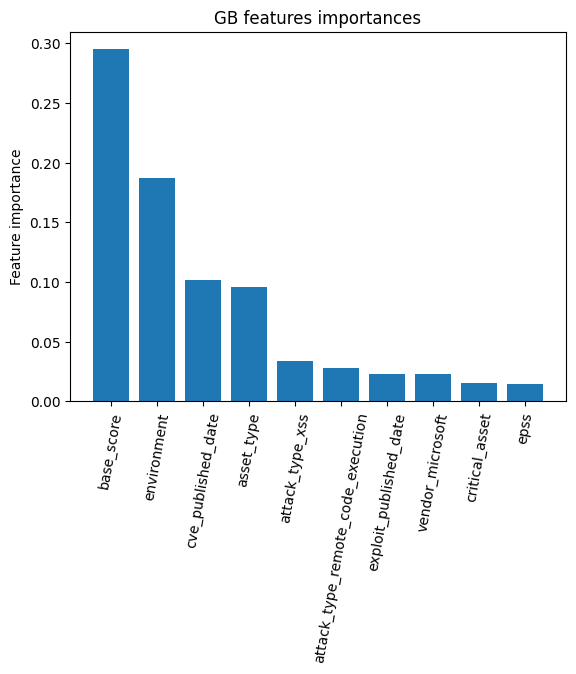

In [9]:
fig, ax = plt.subplots()

ax.bar(indexes, values)
ax.set_title(f'{ESTIMATOR.upper()} features importances')
ax.set_ylabel("Feature importance")

plt.xticks(rotation=80)
plt.show()

## Observações

 - Alguns atributos aparecem como importantes, mas na verdade eles são valores padrões que aparecem na maiorias das entradas.